In [9]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
from tqdm import tqdm

In [2]:
def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

train_path = '../data/seg_train/'
test_path = '../data/seg_test/'

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 501/501 [00:00<00:00, 1252.41it/s]


In [3]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [5]:
results = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
176/176 [==============================] - 116s 639ms/step - loss: 1.1039 - accuracy: 0.5704 - val_loss: 0.7876 - val_accuracy: 0.7075
Epoch 2/10
176/176 [==============================] - 103s 583ms/step - loss: 0.7315 - accuracy: 0.7272 - val_loss: 0.7389 - val_accuracy: 0.7285
Epoch 3/10
176/176 [==============================] - 104s 589ms/step - loss: 0.6031 - accuracy: 0.7767 - val_loss: 0.6259 - val_accuracy: 0.7706
Epoch 4/10
176/176 [==============================] - 105s 597ms/step - loss: 0.4866 - accuracy: 0.8214 - val_loss: 0.5831 - val_accuracy: 0.7852
Epoch 5/10
176/176 [==============================] - 104s 590ms/step - loss: 0.3934 - accuracy: 0.8546 - val_loss: 0.5267 - val_accuracy: 0.8133
Epoch 6/10
176/176 [==============================] - 106s 605ms/step - loss: 0.3159 - accuracy: 0.8841 - val_loss: 0.5642 - val_accuracy: 0.8069
Epoch 7/10
176/176 [==============================] - 105s 595ms/step - loss: 0.2499 - accuracy: 0.9116 - val_loss: 0.6088 -

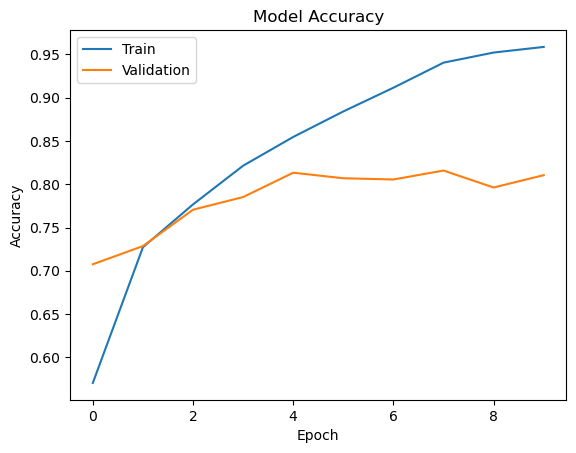

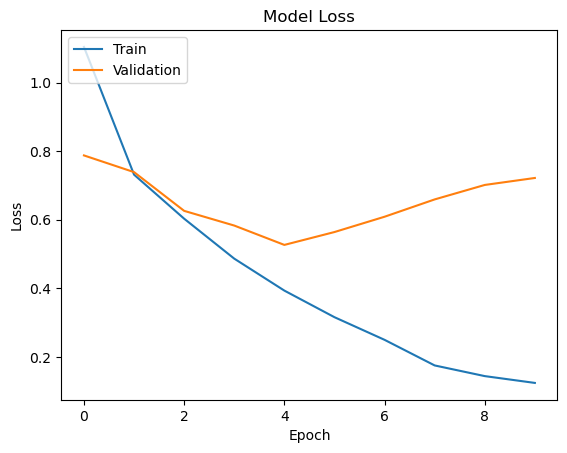

In [6]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

94/94 [==============================] - 8s 88ms/step - loss: 0.6981 - accuracy: 0.8200
Test Set Evaluation Metrics
Confusion Matrix:  [[349   4   0   5  14  65]
 [  5 444   1   3   0  21]
 [ 10   5 433  66  31   8]
 [  8   4  76 395  36   6]
 [ 13   5  39  38 408   7]
 [ 49   7   5   3   6 431]]
F1 Score:  0.819876962030004
Precision:  0.8202347829701147
Recall:  0.82
Accuracy:  0.82
Loss:  0.6981005668640137


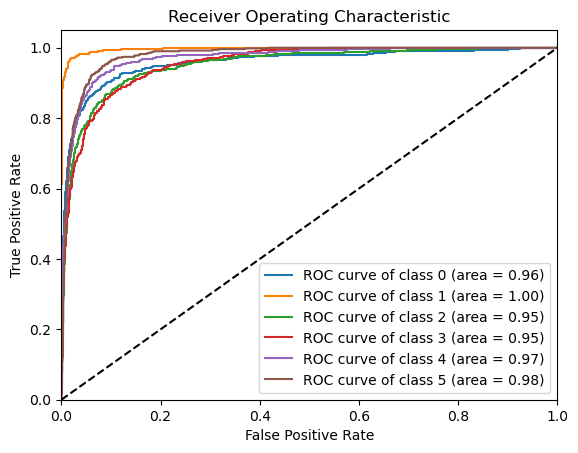

In [8]:
from sklearn.metrics import f1_score,confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)

y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

confusion_matrix = confusion_matrix(y_test, y_pred)
print('Test Set Evaluation Metrics')
print('Confusion Matrix: ', confusion_matrix)

print('F1 Score: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('Loss: ', loss)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 6

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

